In [1]:
import pandas as pd
import numpy as np
import nltk
import sklearn
import string
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from lxml import html
import nltk
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import gensim
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(42)

In [3]:
data_cleaned = pd.read_csv('data_cleaned.csv',
                           converters={"preprocessedTags": lambda x: x.strip("[]").replace("'","").split(", ")})
data_cleaned = data_cleaned.dropna(subset=['desc'])
data_cleaned.head()

,Id,desc,preprocessedTags,Tag1,Tag2,Tag3,Tag4,Tag5
0,48320518,connect two differ databas one applic asp net ...,"[mysql, .net, sql-server]",mysql,.net,sql-server,NaN,NaN
1,48320543,bootstrap 4 navbar disappear resiz screen boot...,"[html, angular, bootstrap-4]",html,angular,bootstrap-4,NaN,NaN
2,48320558,xml transform xslt namespac xml transform xslt...,[xml],xml,NaN,NaN,NaN,NaN
3,48320572,convert timestamp date various format swift co...,"[ios, json, date, datetime]",ios,json,date,datetime,NaN
4,44247,best practic requir time develop best practic ...,[project-management],project-management,NaN,NaN,NaN,NaN


In [4]:
len(data_cleaned)

32841

In [5]:
sample = data_cleaned.sample(frac=.1)
sample.shape[0]

3284

# Train/Test split

In [6]:
X = sample['desc']
#Y = sample[['Tag1', 'Tag2', 'Tag3']].astype(str).values.tolist()
Y = sample['preprocessedTags']
mb = MultiLabelBinarizer()
Y_encoded = mb.fit_transform(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

In [7]:
print("Number of data points in training data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

Number of data points in training data : 2627
Number of data points in test data : 657


# TF-IDF

In [8]:
vectorizer = TfidfVectorizer(max_features=750, ngram_range=(1, 2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

Let's set up a PCA to reduce the number of dimensions

In [9]:
from functions2 import *
from sklearn import preprocessing, decomposition

In [10]:
n_comp = 750

data_pca = pd.DataFrame(X_train_multilabel.todense(), index=X_train.index)

data_pca = data_pca.fillna(data_pca.mean())

#On ne prend que les valeurs
X = data_pca.values

names = data_pca.index

features = data_pca.columns

#Centrage et réduction : 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#Calcul des composantes principales : 
pca = decomposition.PCA(n_components = n_comp)
pca = pca.fit(X_scaled)

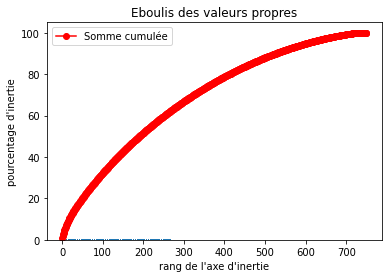

In [11]:
display_scree_plot(pca)

According to this plot, we need 720 to get approximately 100% of the information. As we would reduce the dimension by -20, the pca does not seem to be usefull in this case.

Let's try to plot data with a TSNE to see if we get clusters

In [12]:
X_embedded = TSNE(n_components=2, perplexity=25).fit_transform(X_train_multilabel) # Tries were made with different perplexity, same results
X_embedded_df = pd.DataFrame(X_embedded, index=X_train.index, columns=['V1', 'V2'])

We'll only keep the 4 most used tags, if we take every tags the graphic won't be readable

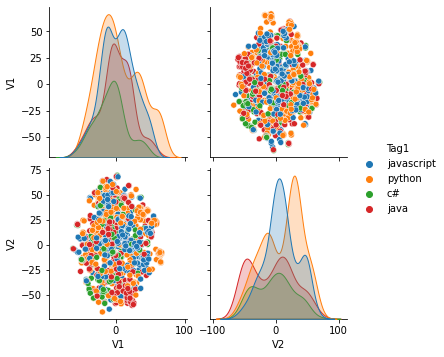

In [13]:
data_tf_plot = pd.merge(X_embedded_df, sample[['Tag1']],
                        left_index=True,
                        right_index=True,
                        how='left')

counter = data_tf_plot.groupby('Tag1').count()[['V1']].sort_values(by='V1', ascending=False)[0:4]
counter = counter.reset_index()['Tag1']
counter = [i for i in counter]
first_tags = data_tf_plot[data_tf_plot['Tag1'].isin(counter)]

sns.pairplot(first_tags, hue='Tag1')
plt.show()

As we can see from this pairplot, there is not cluster visible from TSNE ; But it's quite obvious, when we used PCA to reduce the number of dimensions we saw that we needed 720 features to get all of the information. <br>
Quite normal that we don't get all the information in this pairplot, as TSNE tries to reduce the dimension to 2. <br>
Let's keep those results, we'll use TFIDF in the future model anyway to see the performances

# Word2Vec

As we're using a sample, we know in advance that Word2Vec isn't going to work well. <br>
However some testing was done on the full dataset, and the results were also bad. As my time is limited on this project, I won't modify the code in order to train W2V on full dataset as it does not improve the results.

In [14]:
w2v = Word2Vec(list(X_train.str.split(' ')), size=670,
               window=5, min_count=20, workers=-1, iter=100,
               sg=1)

In [15]:
def document_vector(doc):
    doc = [word for word in doc if word in w2v.wv.vocab]
    return np.mean(w2v[doc], axis=0)

In [16]:
w2v_train = pd.DataFrame(X_train)
w2v_test = pd.DataFrame(X_test)

In [17]:
w2v_train['doc_vector'] = X_train.apply(document_vector)
w2v_test['doc_vector'] = X_test.apply(document_vector)

In [18]:
w2v_train = list(w2v_train['doc_vector'])
w2v_test = list(w2v_test['doc_vector'])

In [19]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(w2v_train)
w2v_train = std_scale.transform(w2v_train)
w2v_test = std_scale.transform(w2v_test)

# Function to log the results

In [20]:
def log_result(model, preprocess, data, pred, time, saving=True, scores=None):
    if scores is not None:
        df = scores        
    else:
        df = pd.DataFrame(columns=['Model', 'Preprocess', 'F1_micro', 'Jaccard_Micro', 'Time'])
        
    f1_micro = metrics.f1_score(data, pred, average = 'micro')
    jaccard_micro = metrics.jaccard_score(data, pred, average = 'micro')
    
    results = {"Model":model, "Preprocess":preprocess,
               "F1_micro":f1_micro, "Jaccard_Micro":jaccard_micro,
               "Time":time}
    
    df = df.append(results, ignore_index=True)
    return df

# Modeling

## With TF-IDF

https://www.quora.com/Whats-the-difference-between-gradient-descent-and-stochastic-gradient-descent

In [21]:
import timeit

### Logistic Regression

In [22]:
time0 = timeit.default_timer()

clf2 = OneVsRestClassifier(LogisticRegression(penalty='l2', n_jobs=-1))
clf2.fit(X_train_multilabel, y_train)
y_pred2 = clf2.predict(X_test_multilabel)

time1 = timeit.default_timer()
time = np.round(time1 - time0, 2)
print(time, "s")

10.4 s


In [23]:
scores = log_result('BASELINE', 'TF-IDF', y_test, y_pred2, time, saving=True, scores=None)
scores

,Model,Preprocess,F1_micro,Jaccard_Micro,Time
0,BASELINE,TF-IDF,0.314839,0.18683,10.4


### SGDC

In [24]:
clf = OneVsRestClassifier(SGDClassifier())

parameters = {
    "estimator__loss": ['hinge', 'log'],
    "estimator__alpha": [1e-3, 1e-2, 1e-1, 1e0],
    "estimator__penalty":['l2', 'l1', 'elasticnet'],
}

model_tunning = GridSearchCV(clf, param_grid=parameters,
                             scoring='f1_micro', n_jobs=-1,
                             verbose=1)

model_tunning.fit(X_train_multilabel, y_train)

print("Best score:", model_tunning.best_score_)
print("Param:", model_tunning.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   21.5s finished


Best score: 0.3545768360176339
Param: {'estimator__alpha': 0.001, 'estimator__loss': 'hinge', 'estimator__penalty': 'l1'}


In [25]:
time0 = timeit.default_timer()

clf = OneVsRestClassifier(SGDClassifier(loss=list(model_tunning.best_params_.values())[1], 
                                        alpha=list(model_tunning.best_params_.values())[0], 
                                        penalty=list(model_tunning.best_params_.values())[2], 
                                        n_jobs=-1))
clf.fit(X_train_multilabel,
        y_train)
y_pred = clf.predict(X_test_multilabel)

time1 = timeit.default_timer()
time = time1 - time0
print(time)

0.6620532999999966


In [26]:
scores = log_result('SGDC', 'TF-IDF', y_test, y_pred, time, saving=True, scores=scores)
scores

,Model,Preprocess,F1_micro,Jaccard_Micro,Time
0,BASELINE,TF-IDF,0.314839,0.186830,10.400000
1,SGDC,TF-IDF,0.381010,0.235338,0.662053


### SVC

In [27]:
param_grid = {'estimator__C': [1, 10],
              'estimator__gamma': [1, 0.1, 0.01],
              'estimator__kernel': ['rbf']}
grid_svc = OneVsRestClassifier(SVC())

grid_svc = GridSearchCV(grid_svc, param_grid, refit=True,
                        scoring='f1_micro', verbose=1, n_jobs=-1)

grid_svc.fit(X_train_multilabel, y_train)

# print best parameter after tuning 
print(grid_svc.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


{'estimator__C': 10, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf'}


In [28]:
time0 = timeit.default_timer()

svc = OneVsRestClassifier(SVC(C=list(grid_svc.best_params_.values())[0],
                              kernel=list(grid_svc.best_params_.values())[2],
                              gamma=list(grid_svc.best_params_.values())[1]))

svc.fit(X_train_multilabel, y_train)
y_pred_svc = svc.predict(X_test_multilabel)

time1 = timeit.default_timer()
time = time1 - time0
print(time)

17.513979099999986


In [29]:
scores = log_result('SVC', 'TF-IDF', y_test, y_pred_svc, time, saving=True, scores=scores)
scores

,Model,Preprocess,F1_micro,Jaccard_Micro,Time
0,BASELINE,TF-IDF,0.314839,0.186830,10.400000
1,SGDC,TF-IDF,0.381010,0.235338,0.662053
2,SVC,TF-IDF,0.489201,0.323803,17.513979


## With Word2Vec

### SGDC

In [30]:
clf = OneVsRestClassifier(SGDClassifier())

parameters = {
    "estimator__loss": ['log'],
    "estimator__alpha": [1e-3, 1e-2, 1e-1],
    "estimator__penalty":['l2', 'l1', 'elasticnet'],
    "estimator__max_iter": [3000]
}

model_tunning = GridSearchCV(clf, param_grid=parameters,
                             scoring='jaccard_micro', 
                             verbose=1, n_jobs=-1)

model_tunning.fit(w2v_train, y_train)

print("Best score:", model_tunning.best_score_)
print("Param:", model_tunning.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  7.1min finished


Best score: 0.04465188782182873
Param: {'estimator__alpha': 0.001, 'estimator__loss': 'log', 'estimator__max_iter': 3000, 'estimator__penalty': 'elasticnet'}


In [31]:
time0 = timeit.default_timer()

clf = OneVsRestClassifier(SGDClassifier(loss=list(model_tunning.best_params_.values())[1],
                                        alpha=list(model_tunning.best_params_.values())[0],
                                        penalty=list(model_tunning.best_params_.values())[3],
                                        max_iter=list(model_tunning.best_params_.values())[2],
                                        n_jobs=-1))
clf.fit(w2v_train, y_train)
y_pred = clf.predict(w2v_test)

time1 = timeit.default_timer()
time = time1 - time0
print(time)

169.65322090000006


In [32]:
scores = log_result('SGDC', 'W2V', y_test, y_pred, time, saving=True, scores=scores)
scores

,Model,Preprocess,F1_micro,Jaccard_Micro,Time
0,BASELINE,TF-IDF,0.314839,0.186830,10.400000
1,SGDC,TF-IDF,0.381010,0.235338,0.662053
2,SVC,TF-IDF,0.489201,0.323803,17.513979
3,SGDC,W2V,0.088623,0.046366,169.653221


### SVC

In [33]:
time0 = timeit.default_timer()

svc = OneVsRestClassifier(SVC(C=10,
                              kernel='rbf',
                              gamma=0.1))
svc.fit(w2v_train, y_train)
y_pred_svc_w2v = svc.predict(w2v_test)


time1 = timeit.default_timer()
time = time1 - time0
print(time)

895.8052956


In [34]:
scores = log_result('SVC', 'W2V', y_test, y_pred_svc_w2v, time, saving=True, scores=scores)
scores

,Model,Preprocess,F1_micro,Jaccard_Micro,Time
0,BASELINE,TF-IDF,0.314839,0.186830,10.400000
1,SGDC,TF-IDF,0.381010,0.235338,0.662053
2,SVC,TF-IDF,0.489201,0.323803,17.513979
3,SGDC,W2V,0.088623,0.046366,169.653221
4,SVC,W2V,0.000000,0.000000,895.805296


# Best Model

Let's find which model has the best score

In [35]:
labels = scores.Model + " : " + scores.Preprocess
F1_micro = scores.F1_micro
Jaccard_Micro = scores.Jaccard_Micro
Time = scores.Time

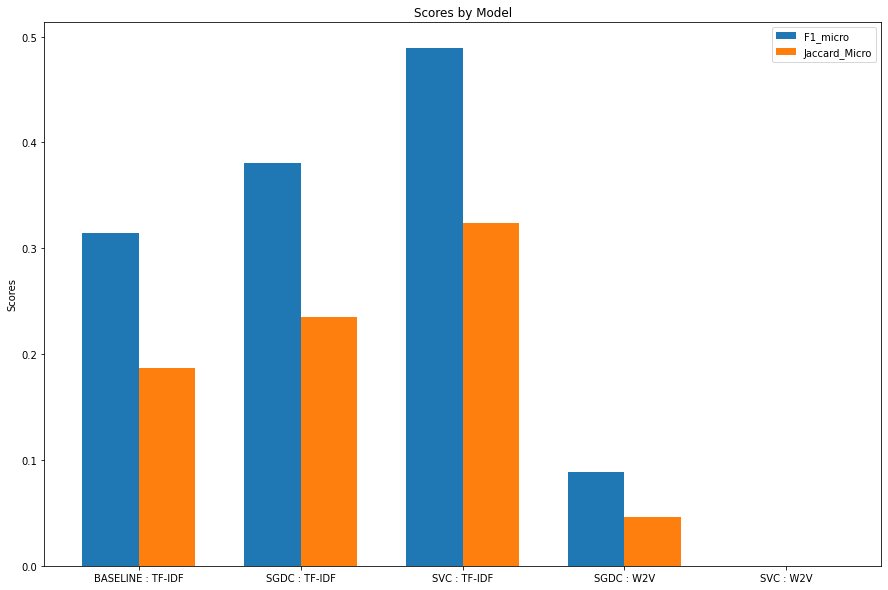

In [36]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x - width/2, F1_micro, width, label='F1_micro')
rects2 = ax.bar(x + width/2, Jaccard_Micro, width, label='Jaccard_Micro')
#rects3 = ax.bar(x + width/2, Time, width, label='Time')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

We can clearly see here that the best model is the SVC with TF-IDF ; It's going to be our model

In [37]:
X = data_cleaned['desc']
#Y = sample[['Tag1', 'Tag2', 'Tag3']].astype(str).values.tolist()
Y = data_cleaned['preprocessedTags']
mb = MultiLabelBinarizer()
Y_encoded = mb.fit_transform(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

In [38]:
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

In [39]:
"""param_grid = {'estimator__C': [1, 10],
              'estimator__gamma': [1, 0.1, 0.01],
              'estimator__kernel': ['rbf']}
grid_svc = OneVsRestClassifier(SVC())

grid_svc = GridSearchCV(grid_svc, param_grid, refit=True,
                        scoring='f1_micro', verbose=1, n_jobs=-1)

grid_svc.fit(X_train_multilabel, y_train)

# print best parameter after tuning 
print(grid_svc.best_params_)"""

# Using the parameters of svc tfidf as the results are always the same
# This cross validation takes 2h to run 

"param_grid = {'estimator__C': [1, 10],\n              'estimator__gamma': [1, 0.1, 0.01],\n              'estimator__kernel': ['rbf']}\ngrid_svc = OneVsRestClassifier(SVC())\n\ngrid_svc = GridSearchCV(grid_svc, param_grid, refit=True,\n                        scoring='f1_micro', verbose=1, n_jobs=-1)\n\ngrid_svc.fit(X_train_multilabel, y_train)\n\n# print best parameter after tuning \nprint(grid_svc.best_params_)"

In [40]:
time0 = timeit.default_timer()

svc = OneVsRestClassifier(SVC(C=list(grid_svc.best_params_.values())[0],
                              kernel=list(grid_svc.best_params_.values())[2],
                              gamma=list(grid_svc.best_params_.values())[1]))

svc.fit(X_train_multilabel, y_train)
y_pred_svc = svc.predict(X_test_multilabel)

time1 = timeit.default_timer()
time = time1 - time0
print(time)

1526.7778715


In [41]:
scores = log_result('svc_final', 'tf_idf', y_test, y_pred_svc, time, saving=True, scores=None)
scores

,Model,Preprocess,F1_micro,Jaccard_Micro,Time
0,svc_final,tf_idf,0.617965,0.447141,1526.777871


In [42]:
X = data_cleaned['desc']
#Y = sample[['Tag1', 'Tag2', 'Tag3']].astype(str).values.tolist()
Y = data_cleaned['preprocessedTags']
mb = MultiLabelBinarizer()
Y_encoded = mb.fit_transform(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

# Saving Model

In [43]:
pickle.dump(vectorizer, open('Flask/tfidf', 'wb'))
pickle.dump(svc, open('Flask/model', 'wb'))
pickle.dump(mb, open('Flask/mb', 'wb'))

In [44]:
classes_convertor = mb.classes_
classes_convertor = mb.classes_
classes_convertor = pd.DataFrame(classes_convertor)
classes_convertor.to_csv('Flask/classes_convertor.csv')

# Unsupervized approach

In [45]:
import gensim

In [46]:
import gensim.corpora as corpora

data_text = list(X.str.split(' '))

# Create Dictionary
id2word = corpora.Dictionary(data_text)

# Create Corpus
texts = data_text.copy()

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [47]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=215,
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [48]:
import pyLDAvis.gensim 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
101    0.132833 -0.208107       1        1  1.997149
147    0.280190  0.036146       2        1  1.989164
52    -0.126846  0.181025       3        1  1.953709
14     0.280869 -0.028122       4        1  1.794652
19     0.271213  0.013966       5        1  1.749534
...         ...       ...     ...      ...       ...
80    -0.084354  0.041552     211        1  0.092449
133   -0.083725  0.041815     212        1  0.088880
37    -0.017456  0.039885     213        1  0.084428
93    -0.084362  0.019913     214        1  0.074514
184   -0.004935 -0.033809     215        1  0.065300

[215 rows x 5 columns], topic_info=      Term          Freq         Total  Category  logprob  loglift
208      c  17130.000000  17130.000000   Default  30.0000  30.0000
429   valu  18900.000000  18900.000000   Default  29.0000  29.0000
4     data  17247.000000  17247.000000   Default  28.0000  28.0000
40    file  16235.000000  16235.000000   Default  27.0000  27.0000
50    name  13979.000000  13979.000000   Default  26.0000  26.0000
..     ...           ...           ...       ...      ...      ...
33    code     10.496935  19015.608330  Topic215  -5.0923  -0.1680
106    get      7.513059  19682.341218  Topic215  -5.4267  -0.5369
63    want      6.375410  13366.376736  Topic215  -5.5909  -0.3141
99   could      5.339570   3762.814848  Topic215  -5.7682   0.7762
508     ad      5.046412   2526.053304  Topic215  -5.8247   1.1182

[8793 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
381      18  0.006009          00
381      41  0.004936          00
381      78  0.988877          00
1556     22  0.998653         000
336     185  0.993146        0000
...     ...       ...         ...
1732    195  0.006302        zone
2240     96  0.038931        zoom
2240    138  0.181680        zoom
2240    162  0.765652        zoom
2802      7  0.998108  zygoteinit

[24679 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[102, 148, 53, 15, 20, 67, 25, 122, 82, 64, 26, 144, 62, 2, 165, 116, 145, 171, 208, 101, 14, 66, 41, 149, 40, 147, 11, 123, 177, 193, 44, 54, 176, 160, 154, 10, 60, 5, 17, 178, 32, 186, 46, 85, 86, 190, 114, 23, 56, 130, 3, 21, 59, 170, 27, 150, 72, 141, 179, 155, 34, 104, 78, 126, 87, 75, 50, 112, 31, 97, 163, 140, 192, 52, 77, 70, 128, 172, 146, 153, 6, 197, 37, 174, 24, 55, 168, 205, 110, 19, 125, 48, 182, 191, 88, 84, 175, 76, 199, 49, 18, 194, 89, 16, 80, 159, 117, 71, 189, 136, 212, 137, 43, 214, 169, 8, 107, 120, 184, 95, 215, 91, 13, 188, 98, 151, 180, 135, 74, 204, 7, 36, 69, 143, 119, 68, 213, 138, 22, 129, 211, 29, 181, 200, 166, 198, 111, 210, 156, 33, 108, 118, 99, 73, 58, 157, 93, 63, 42, 121, 105, 100, 61, 167, 202, 109, 133, 90, 161, 164, 9, 158, 45, 173, 196, 209, 183, 4, 132, 106, 1, 207, 142, 201, 103, 195, 139, 65, 203, 115, 131, 35, 152, 206, 187, 51, 92, 83, 162, 47, 127, 124, 28, 39, 96, 79, 57, 30, 113, 12, 81, 134, 38, 94, 185])